In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pygam import LinearGAM, s
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Data Overview

In [4]:
yfinance_data = pd.read_csv('yfinance_data.csv')
yfinance_data['date'] = pd.to_datetime(yfinance_data['date'])
eur_usd_data = yfinance_data.loc[yfinance_data['currency']=='EUR-USD']
eur_usd_data

,currency,date,Close,High,Low,Open,Volume
0,EUR-USD,2015-01-05,1.194643,1.197590,1.188909,1.195500,0
1,EUR-USD,2015-01-06,1.193902,1.197000,1.188693,1.193830,0
2,EUR-USD,2015-01-07,1.187536,1.190000,1.180401,1.187479,0
3,EUR-USD,2015-01-08,1.183600,1.184806,1.175601,1.183894,0
4,EUR-USD,2015-01-09,1.179607,1.183830,1.176831,1.179426,0
...,...,...,...,...,...,...,...
2597,EUR-USD,2024-12-23,1.043308,1.044823,1.038594,1.043308,0
2598,EUR-USD,2024-12-24,1.040583,1.041124,1.038745,1.040583,0
2599,EUR-USD,2024-12-25,1.040258,1.043297,1.040150,1.040258,0
2600,EUR-USD,2024-12-26,1.039955,1.042535,1.039145,1.039955,0


In [5]:
eur_usd_data.describe()

,date,Close,High,Low,Open,Volume
count,2602,2602.000000,2602.000000,2602.000000,2602.000000,2602.0
mean,2020-01-01 17:33:42.751729408,1.119090,1.122632,1.115447,1.119071,0.0
min,2015-01-05 00:00:00,0.959619,0.967006,0.954016,0.959619,0.0
25%,2017-07-03 06:00:00,1.084410,1.087587,1.081137,1.084399,0.0
50%,2020-01-02 12:00:00,1.114771,1.118249,1.111247,1.114784,0.0
75%,2022-06-30 18:00:00,1.156200,1.159944,1.152994,1.156086,0.0
max,2024-12-27 00:00:00,1.251001,1.255808,1.245051,1.251267,0.0
std,NaN,0.052219,0.052005,0.052398,0.052211,0.0


In [6]:
eur_usd_data.isnull().sum()

currency    0
date        0
Close       0
High        0
Low         0
Open        0
Volume      0
dtype: int64

In [7]:
eur_usd_data['Volume'].unique()

array([0])

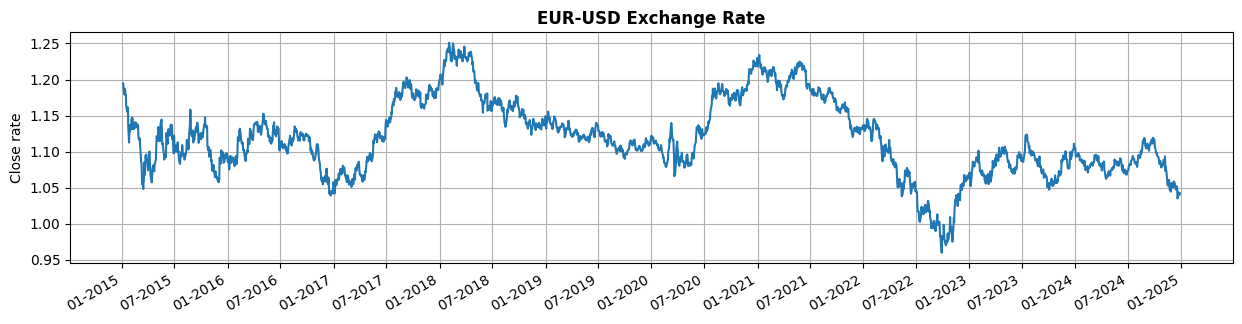

In [8]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=eur_usd_data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('EUR-USD Exchange Rate', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show()

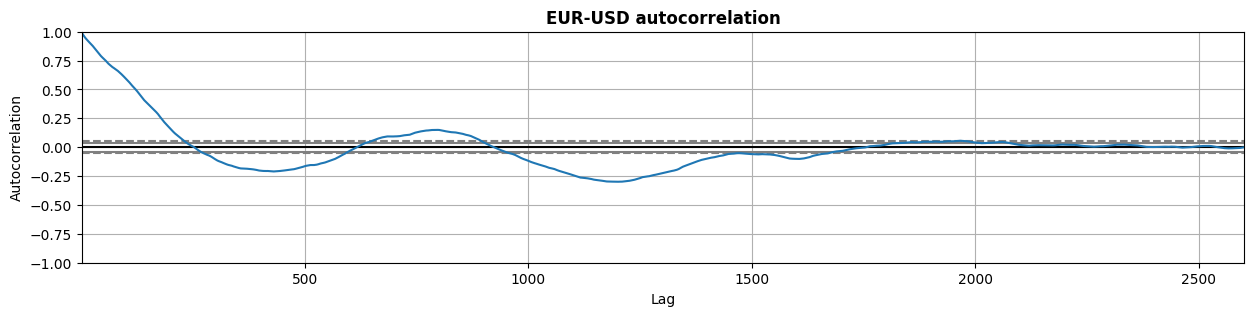

In [9]:
# autocorr = sm.tsa.acf(eur_usd_data['Close'], nlags=eur_usd_data.shape[0]-1)

plt.subplots(figsize=(15, 3))
pd.plotting.autocorrelation_plot(eur_usd_data['Close'])  
plt.title('EUR-USD autocorrelation', fontweight='bold')
plt.show()

In [10]:
eur_usd_data['ma5'] = eur_usd_data['Close'].rolling(5).mean()
eur_usd_data['ma20'] = eur_usd_data['Close'].rolling(20).mean()
eur_usd_data['ma60'] = eur_usd_data['Close'].rolling(60).mean()
eur_usd_data

,currency,date,Close,High,Low,Open,Volume,ma5,ma20,ma60
0,EUR-USD,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,NaN,NaN,NaN
1,EUR-USD,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,NaN,NaN,NaN
2,EUR-USD,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,NaN,NaN,NaN
3,EUR-USD,2015-01-08,1.183600,1.184806,1.175601,1.183894,0,NaN,NaN,NaN
4,EUR-USD,2015-01-09,1.179607,1.183830,1.176831,1.179426,0,1.187857,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2597,EUR-USD,2024-12-23,1.043308,1.044823,1.038594,1.043308,0,1.043214,1.050115,1.070537
2598,EUR-USD,2024-12-24,1.040583,1.041124,1.038745,1.040583,0,1.040983,1.049923,1.069319
2599,EUR-USD,2024-12-25,1.040258,1.043297,1.040150,1.040258,0,1.039134,1.049480,1.068217
2600,EUR-USD,2024-12-26,1.039955,1.042535,1.039145,1.039955,0,1.040120,1.048665,1.067136


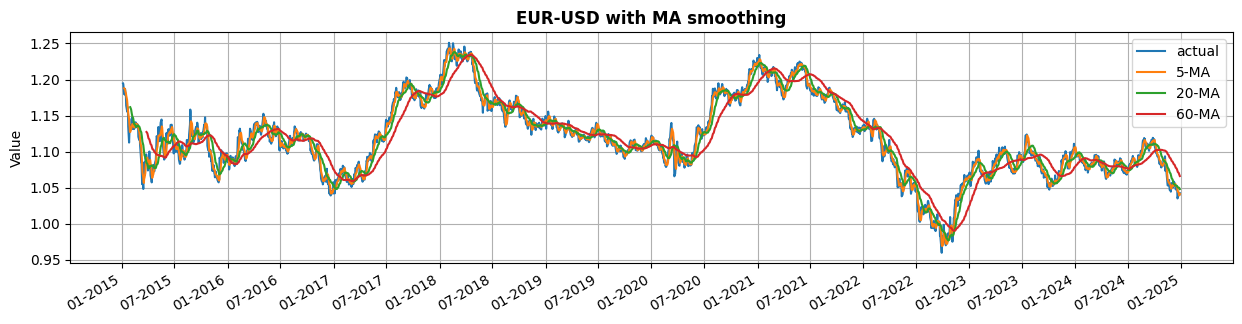

In [11]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=eur_usd_data, label='actual')
ax.plot('date', 'ma5', data=eur_usd_data, label='5-MA')
ax.plot('date', 'ma20', data=eur_usd_data, label='20-MA')
ax.plot('date', 'ma60', data=eur_usd_data, label='60-MA')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Value')
plt.title('EUR-USD with MA smoothing', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.legend()
plt.show()

# Classical Decomposition

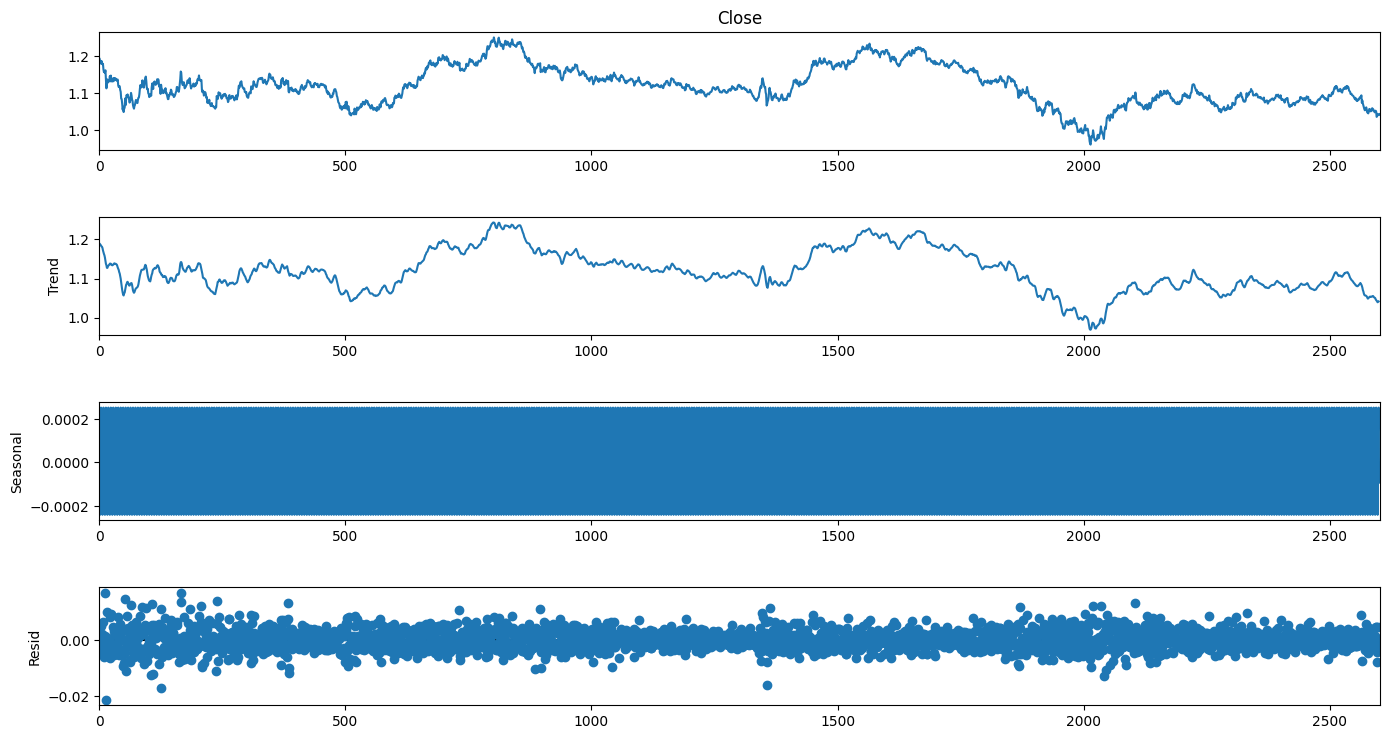

In [12]:
components = seasonal_decompose(eur_usd_data['Close'], period=5)
fig = components.plot()
fig.set_size_inches(16, 8)

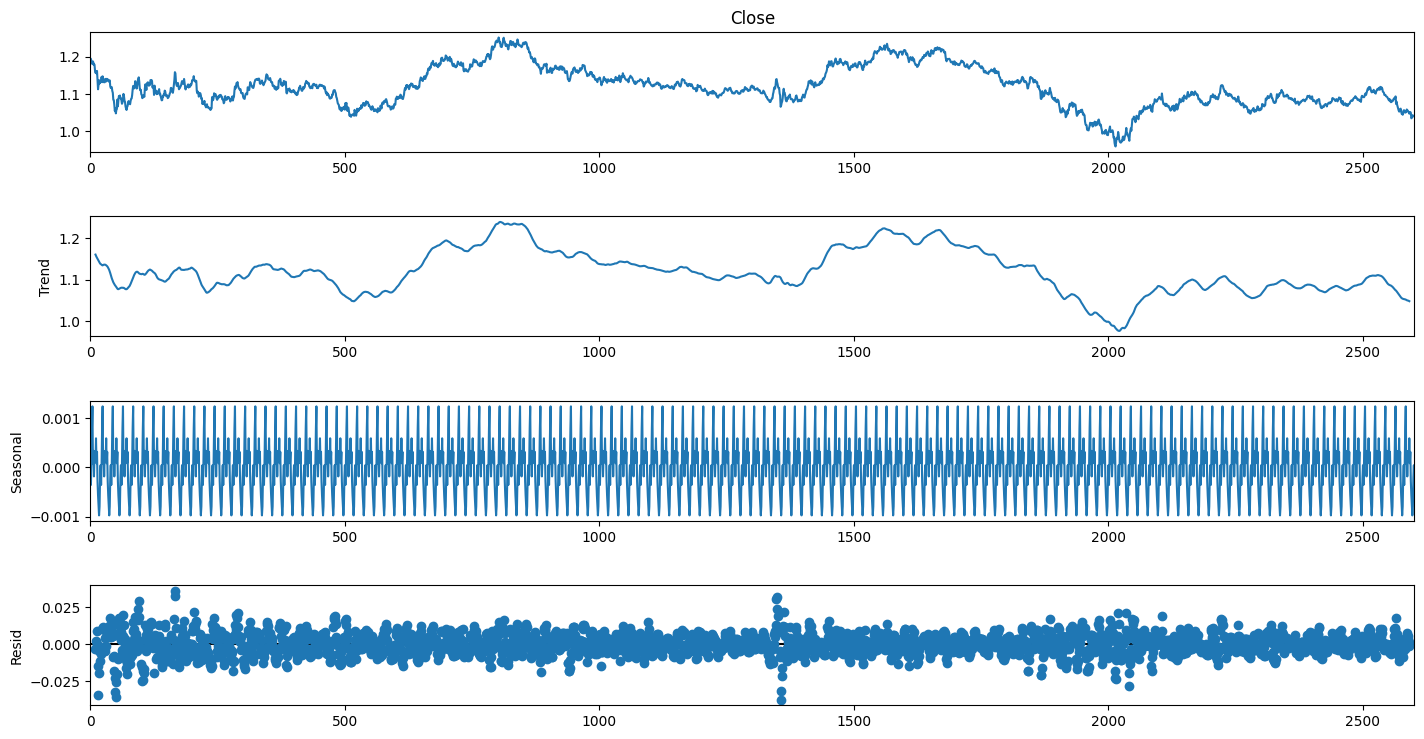

In [13]:
components = seasonal_decompose(eur_usd_data['Close'], period=20)
fig = components.plot()
fig.set_size_inches(16, 8)

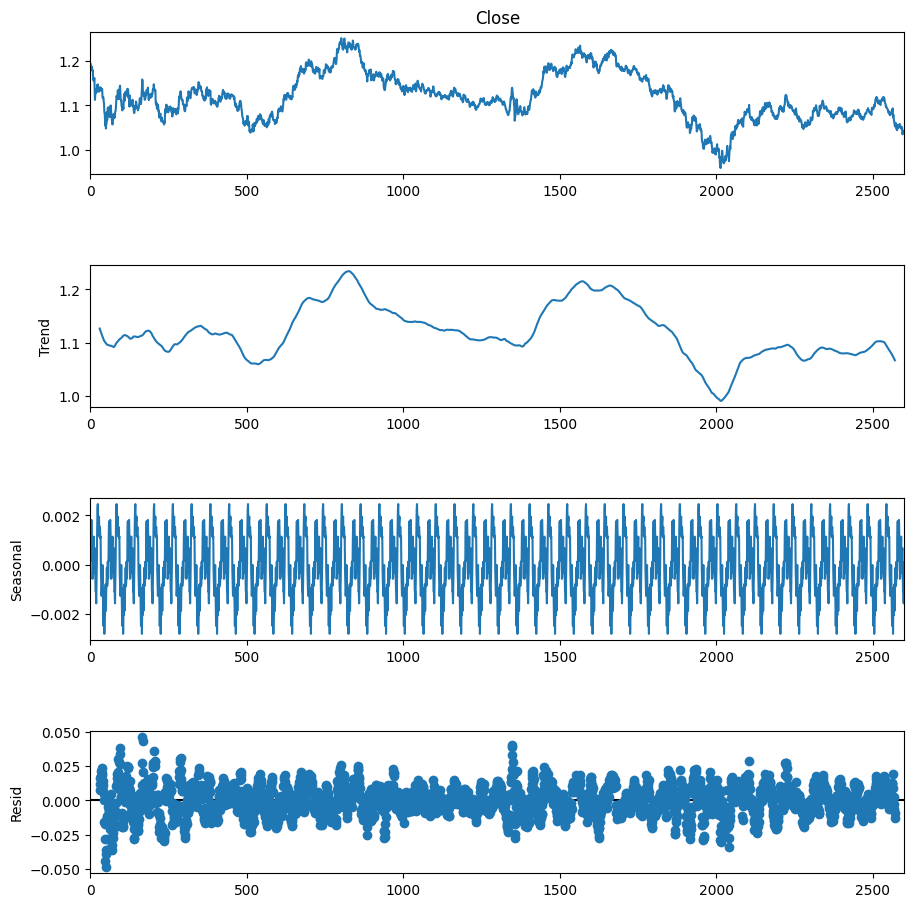

In [14]:
components = seasonal_decompose(eur_usd_data['Close'], period=60)
fig = components.plot()
fig.set_size_inches(10, 10)

# Train-Test Split

In [15]:
n_samples = len(eur_usd_data)
eur_usd_train = eur_usd_data.iloc[0:int(n_samples*0.8)]
eur_usd_test= eur_usd_data.iloc[int(n_samples*0.8):]

In [16]:
eur_usd_data.iloc[int(n_samples*0.8)]

currency                EUR-USD
date        2022-12-30 00:00:00
Close                  1.066075
High                   1.069793
Low                     1.06392
Open                   1.066075
Volume                        0
ma5                    1.064704
ma20                   1.059329
ma60                   1.023708
Name: 2081, dtype: object

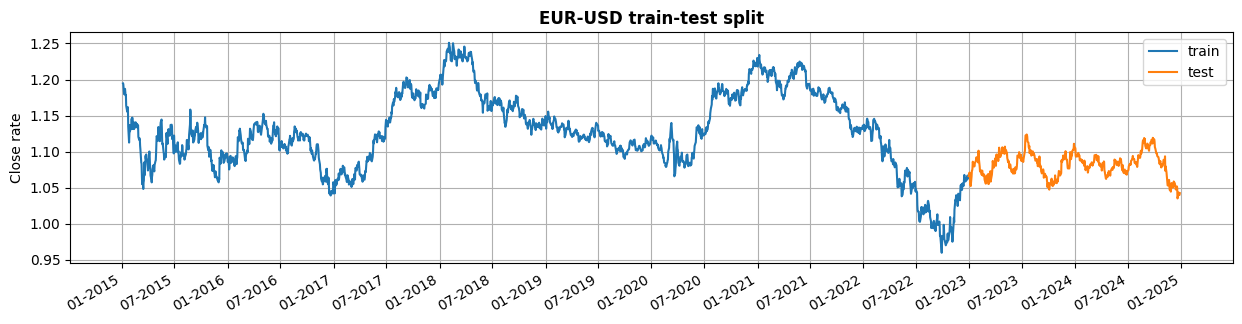

In [17]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=eur_usd_train, label='train')
ax.plot('date', 'Close', data=eur_usd_test, label='test')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('EUR-USD train-test split', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

# Benchmark Models

In [18]:
# Mean mthod
eur_usd_test['Close_mean'] = eur_usd_train['Close'].mean()

# Naive method
eur_usd_test['Close_naive'] = eur_usd_train['Close'].iloc[-1]

# Seasonal naive method
period = 60
last_season_values = eur_usd_train['Close'].iloc[-period:]
eur_usd_test['Close_ss_naive'] = last_season_values.values.repeat(len(eur_usd_test)//period + 1)[:len(eur_usd_test)]

# Drift method
first_value = eur_usd_train['Close'].iloc[0]
last_value = eur_usd_train['Close'].iloc[-1]
slope = (last_value-first_value) / (len(eur_usd_train)-1)

eur_usd_test['Close_drift'] = eur_usd_train['Close'].iloc[-1] + slope*range(1, len(eur_usd_test)+1)

eur_usd_test


,currency,date,Close,High,Low,Open,Volume,ma5,ma20,ma60,Close_mean,Close_naive,Close_ss_naive,Close_drift
2081,EUR-USD,2022-12-30,1.066075,1.069793,1.063920,1.066075,0,1.064704,1.059329,1.023708,1.128337,1.062925,0.978905,1.062862
2082,EUR-USD,2023-01-02,1.070973,1.071237,1.065326,1.070973,0,1.065543,1.060157,1.025332,1.128337,1.062925,0.978905,1.062798
2083,EUR-USD,2023-01-03,1.067771,1.068262,1.052155,1.067771,0,1.066292,1.061061,1.026945,1.128337,1.062925,0.978905,1.062735
2084,EUR-USD,2023-01-04,1.054685,1.063151,1.054596,1.054685,0,1.064486,1.061450,1.028356,1.128337,1.062925,0.978905,1.062672
2085,EUR-USD,2023-01-05,1.060637,1.063264,1.051558,1.060637,0,1.064028,1.061915,1.029853,1.128337,1.062925,0.978905,1.062608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,EUR-USD,2024-12-23,1.043308,1.044823,1.038594,1.043308,0,1.043214,1.050115,1.070537,1.128337,1.062925,1.064022,1.030186
2598,EUR-USD,2024-12-24,1.040583,1.041124,1.038745,1.040583,0,1.040983,1.049923,1.069319,1.128337,1.062925,1.064022,1.030122
2599,EUR-USD,2024-12-25,1.040258,1.043297,1.040150,1.040258,0,1.039134,1.049480,1.068217,1.128337,1.062925,1.064022,1.030059
2600,EUR-USD,2024-12-26,1.039955,1.042535,1.039145,1.039955,0,1.040120,1.048665,1.067136,1.128337,1.062925,1.064022,1.029996


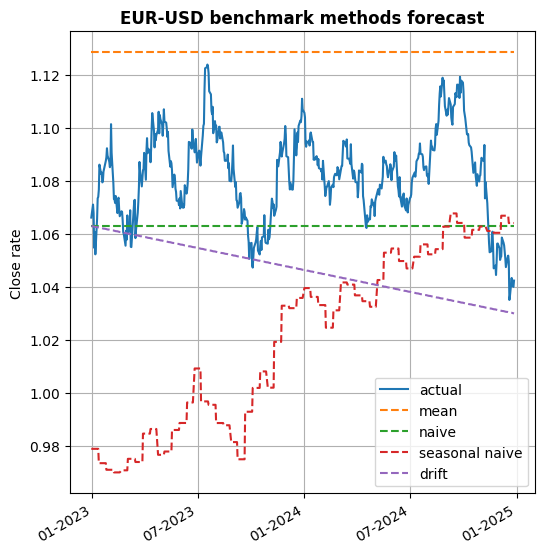

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot('date', 'Close', data=eur_usd_train, label='train')
ax.plot('date', 'Close', data=eur_usd_test, label='actual')
ax.plot('date', 'Close_mean', data=eur_usd_test, linestyle='--', label='mean')
ax.plot('date', 'Close_naive', data=eur_usd_test, linestyle='--', label='naive')
ax.plot('date', 'Close_ss_naive', data=eur_usd_test, linestyle='--', label='seasonal naive')
ax.plot('date', 'Close_drift', data=eur_usd_test, linestyle='--', label='drift')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('EUR-USD benchmark methods forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [22]:
def calculate_metrics(df, actual_col, benchmark_cols):
    """
    Calculate statistical metrics for each benchmark column against the actual column.

    :param df: DataFrame with actual and predicted data.
    :param actual_col: Column name of the actual values.
    :param benchmark_cols: List of column names for benchmark (predicted) values.
    :return: DataFrame with calculated metrics for each benchmark column.
    """
    metrics = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R2'])

    for col in benchmark_cols:
        actual = df[actual_col]
        predicted = df[col]

        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        r2 = r2_score(actual, predicted)

        metrics[col] = [np.round(mae, 4), np.round(mse, 4), np.round(rmse, 4), np.round(mape, 4), np.round(r2, 4)]

    return metrics

In [23]:
benchmark_metrics = calculate_metrics(eur_usd_test, actual_col='Close', benchmark_cols=benchmark_cols)
benchmark_metrics

,Close_mean,Close_naive,Close_ss_naive,Close_drift
MAE,0.0462,0.0218,0.0630,0.0359
MSE,0.0024,0.0007,0.0050,0.0016
RMSE,0.0492,0.0256,0.0710,0.0406
MAPE,4.2933,1.9993,5.8100,3.2974
R2,-7.4737,-1.2954,-16.6655,-4.7726


# ARIMA

In [24]:
arima_params = [(p, d, q) for p in [0, 1] for d in [0, 1, 2] for q in [0, 1, 2]]
df_train_copy = eur_usd_train.copy()

for p, d, q in arima_params:
    arima_model = ARIMA(df_train_copy['Close'], order=(p, d, q)).fit()
    print(p, d, q, 'aicc', int(arima_model.aicc))
    preds = arima_model.predict(start=0, end=len(eur_usd_test) - 1)
    reindex_preds = pd.Series(preds.values, index=eur_usd_test.index)
    eur_usd_test[f'Close_arima_{(p, d, q)}']  = reindex_preds

0 0 0 aicc -6242
0 0 1 aicc -8846
0 0 2 aicc -10653
0 1 0 aicc -15579
0 1 1 aicc -15577
0 1 2 aicc -15575
0 2 0 aicc -14130
0 2 1 aicc -15559
0 2 2 aicc -15557
1 0 0 aicc -15584
1 0 1 aicc -15582
1 0 2 aicc -15580
1 1 0 aicc -15577
1 1 1 aicc -15575
1 1 2 aicc -15574
1 2 0 aicc -14711
1 2 1 aicc -15557
1 2 2 aicc -15366


In [25]:
eur_usd_test

,currency,date,Close,High,Low,Open,Volume,ma5,ma20,ma60,...,"Close_arima_(0, 2, 2)","Close_arima_(1, 0, 0)","Close_arima_(1, 0, 1)","Close_arima_(1, 0, 2)","Close_arima_(1, 1, 0)","Close_arima_(1, 1, 1)","Close_arima_(1, 1, 2)","Close_arima_(1, 2, 0)","Close_arima_(1, 2, 1)","Close_arima_(1, 2, 2)"
2081,EUR-USD,2022-12-30,1.066075,1.069793,1.063920,1.066075,0,1.064704,1.059329,1.023708,...,0.000000,1.128337,1.128337,1.128337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2082,EUR-USD,2023-01-02,1.070973,1.071237,1.065326,1.070973,0,1.065543,1.060157,1.025332,...,1.791965,1.194270,1.194275,1.194275,1.194643,1.194643,1.194643,1.791965,1.791965,1.791965
2083,EUR-USD,2023-01-03,1.067771,1.068262,1.052155,1.067771,0,1.066292,1.061061,1.026945,...,1.193160,1.193533,1.193534,1.193535,1.193902,1.193902,1.193901,1.193160,1.193160,1.193160
2084,EUR-USD,2023-01-04,1.054685,1.063151,1.054596,1.054685,0,1.064486,1.061450,1.028356,...,1.183981,1.187203,1.187189,1.187199,1.187536,1.187539,1.187543,1.183953,1.183981,1.183952
2085,EUR-USD,2023-01-05,1.060637,1.063264,1.051558,1.060637,0,1.064028,1.061915,1.029853,...,1.179919,1.183289,1.183282,1.183334,1.183600,1.183604,1.183674,1.178462,1.179919,1.179865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,EUR-USD,2024-12-23,1.043308,1.044823,1.038594,1.043308,0,1.043214,1.050115,1.070537,...,1.045139,1.045944,1.045944,1.045933,1.045478,1.045477,1.045483,1.046791,1.045139,1.044872
2598,EUR-USD,2024-12-24,1.040583,1.041124,1.038745,1.040583,0,1.040983,1.049923,1.069319,...,1.045359,1.046162,1.046158,1.046140,1.045697,1.045696,1.045674,1.046655,1.045359,1.045241
2599,EUR-USD,2024-12-25,1.040258,1.043297,1.040150,1.040258,0,1.039134,1.049480,1.068217,...,1.045898,1.046695,1.046692,1.046686,1.046233,1.046232,1.046239,1.046612,1.045898,1.045930
2600,EUR-USD,2024-12-26,1.039955,1.042535,1.039145,1.039955,0,1.040120,1.048665,1.067136,...,1.041349,1.042186,1.042170,1.042162,1.041699,1.041701,1.041689,1.039674,1.041350,1.040718


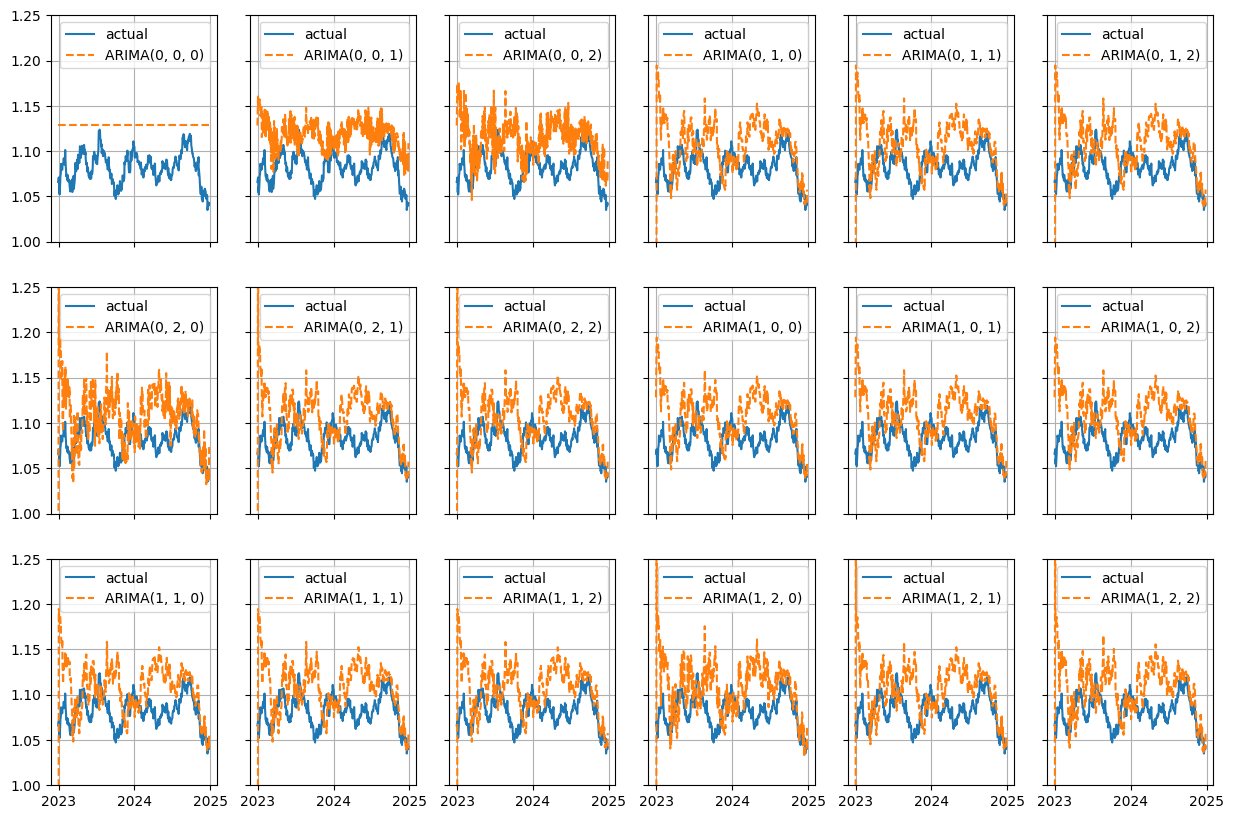

In [26]:
nr, nc = 3, 6
fig, axes = plt.subplots(nrows=nr, ncols=nc, sharex=True, sharey=True, figsize=(15, 10))
axes = axes.reshape(nr*nc)

for ax, params in zip(axes, arima_params):
    p, d, q = params[0], params[1], params[2]
    ax.plot('date', 'Close', data=eur_usd_test, label='actual')
    ax.plot('date', f'Close_arima_{(p, d, q)}', data=eur_usd_test, linestyle='--', label=f'ARIMA{(p, d, q)}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 13)))
    ax.legend()
    ax.grid(True)
    ax.set_ylim([1, 1.25])

plt.show()

In [27]:
arima_cols = [f'Close_arima_{(p, d, q)}' for p, d, q in arima_params]
arima_metrics = calculate_metrics(eur_usd_test, actual_col='Close', benchmark_cols=arima_cols)
arima_metrics

,"Close_arima_(0, 0, 0)","Close_arima_(0, 0, 1)","Close_arima_(0, 0, 2)","Close_arima_(0, 1, 0)","Close_arima_(0, 1, 1)","Close_arima_(0, 1, 2)","Close_arima_(0, 2, 0)","Close_arima_(0, 2, 1)","Close_arima_(0, 2, 2)","Close_arima_(1, 0, 0)","Close_arima_(1, 0, 1)","Close_arima_(1, 0, 2)","Close_arima_(1, 1, 0)","Close_arima_(1, 1, 1)","Close_arima_(1, 1, 2)","Close_arima_(1, 2, 0)","Close_arima_(1, 2, 1)","Close_arima_(1, 2, 2)"
MAE,0.0462,0.0368,0.0344,0.0331,0.0331,0.0331,0.0350,0.0339,0.0339,0.0312,0.0312,0.0312,0.0331,0.0331,0.0331,0.0346,0.0339,0.0343
MSE,0.0024,0.0018,0.0017,0.0038,0.0038,0.0038,0.0048,0.0047,0.0047,0.0016,0.0016,0.0016,0.0038,0.0038,0.0038,0.0048,0.0047,0.0047
RMSE,0.0492,0.0424,0.0412,0.0614,0.0614,0.0614,0.0693,0.0685,0.0685,0.0399,0.0399,0.0399,0.0614,0.0614,0.0614,0.0691,0.0685,0.0689
MAPE,4.2928,3.4223,3.1937,3.0748,3.0748,3.0747,3.2510,3.1483,3.1483,2.8958,2.8958,2.8957,3.0748,3.0748,3.0747,3.2188,3.1483,3.1888
R2,-7.4721,-5.2942,-4.9514,-12.1891,-12.1891,-12.1887,-15.8348,-15.4475,-15.4476,-4.5663,-4.5666,-4.5663,-12.1891,-12.1890,-12.1888,-15.7249,-15.4476,-15.6177


In [28]:
for p, d, q in arima_params:
    position = pd.Series(np.sign(eur_usd_test[f'Close_arima_{(p, d, q)}'] - eur_usd_test['Close'].shift(1)))
    eur_usd_test[f'daily_return_arima_{(p, d, q)}'] = position.shift(1) * eur_usd_test['daily_return']
    eur_usd_test[f'cum_return_arima_{(p, d, q)}'] = eur_usd_test[f'daily_return_arima_{(p, d, q)}'].cumsum().apply(np.exp)

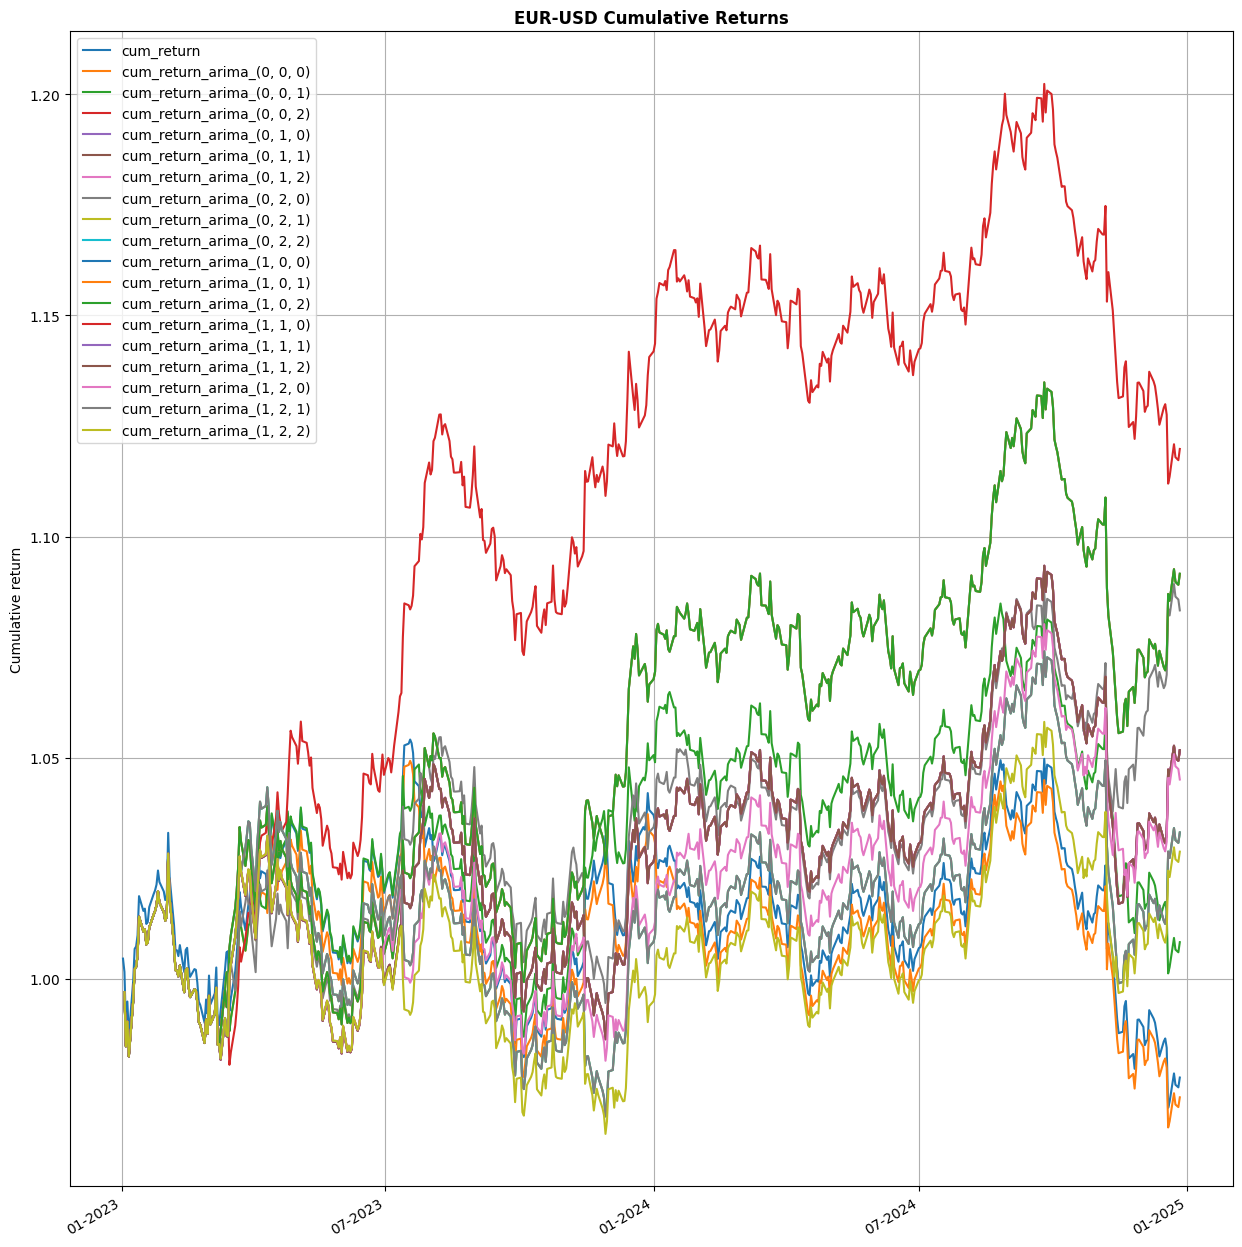

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot('date', 'cum_return', data=eur_usd_test, label='cum_return')

for p, d, q in arima_params:
    ax.plot('date', f'cum_return_arima_{(p, d, q)}', data=eur_usd_test, label=f'cum_return_arima_{(p, d, q)}')

plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Cumulative return')
plt.title('EUR-USD Cumulative Returns', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

# GAM

In [30]:
df_train_copy = eur_usd_train.copy()
df_train_copy['date'] = pd.to_datetime(df_train_copy['date'])
df_train_copy['year'] = df_train_copy['date'].dt.year
df_train_copy['month'] = df_train_copy['date'].dt.month
df_train_copy['day'] = df_train_copy['date'].dt.day
df_train_copy['weekday'] = df_train_copy['date'].dt.weekday

n_days = 5
df_train_copy[f'lag_{n_days}'] = df_train_copy['Close'].shift(n_days)
df_train_copy = df_train_copy.dropna()

features = ['year', 'month', 'day', 'weekday', f'lag_{n_days}']
X = df_train_copy[features]
y = df_train_copy['Close']

gam_model = LinearGAM(s(1) + s(2) + s(3) + s(4)).fit(X, y)

In [31]:
df_train_copy

,currency,date,Close,High,Low,Open,Volume,ma5,ma20,ma60,year,month,day,weekday,lag_5
59,EUR-USD,2015-03-27,1.088637,1.089538,1.080530,1.088554,0,1.090409,1.084462,1.127210,2015,3,27,4,1.066894
60,EUR-USD,2015-03-30,1.088495,1.088495,1.081110,1.088198,0,1.091576,1.083077,1.125441,2015,3,30,0,1.082661
61,EUR-USD,2015-03-31,1.083025,1.084352,1.071765,1.082907,0,1.089281,1.081333,1.123593,2015,3,31,1,1.094499
62,EUR-USD,2015-04-01,1.073814,1.080030,1.072130,1.074102,0,1.086003,1.079113,1.121697,2015,4,1,2,1.090203
63,EUR-USD,2015-04-02,1.076994,1.089690,1.075269,1.076983,0,1.082193,1.077553,1.119921,2015,4,2,3,1.096047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,EUR-USD,2022-12-23,1.060333,1.063117,1.058795,1.060333,0,1.060800,1.053110,1.017164,2022,12,23,4,1.064056
2077,EUR-USD,2022-12-26,1.066780,1.063717,1.060895,1.066780,0,1.062456,1.054611,1.018623,2022,12,26,0,1.058504
2078,EUR-USD,2022-12-27,1.064022,1.066900,1.061244,1.064022,0,1.062969,1.056084,1.019970,2022,12,27,1,1.061458
2079,EUR-USD,2022-12-28,1.063717,1.067430,1.061391,1.063717,0,1.063172,1.057648,1.021058,2022,12,28,2,1.062699


In [32]:
df_test_copy = eur_usd_test.copy()
df_test_copy['date'] = pd.to_datetime(df_test_copy['date'])
df_test_copy['year'] = df_test_copy['date'].dt.year
df_test_copy['month'] = df_test_copy['date'].dt.month
df_test_copy['day'] = df_test_copy['date'].dt.day
df_test_copy['weekday'] = df_test_copy['date'].dt.weekday

n_days = 5
df_test_copy[f'lag_{n_days}'] = pd.concat((df_train_copy['Close'][-n_days:], df_test_copy['Close'])).shift(n_days)

X_test = df_test_copy[features]

preds = gam_model.predict(X_test)
eur_usd_test['Close_gam'] = preds
eur_usd_test['Close_gam']

2081    1.065416
2082    1.069754
2083    1.067343
2084    1.068715
2085    1.068264
          ...   
2597    1.055490
2598    1.055907
2599    1.054148
2600    1.037996
2601    1.040186
Name: Close_gam, Length: 521, dtype: float64

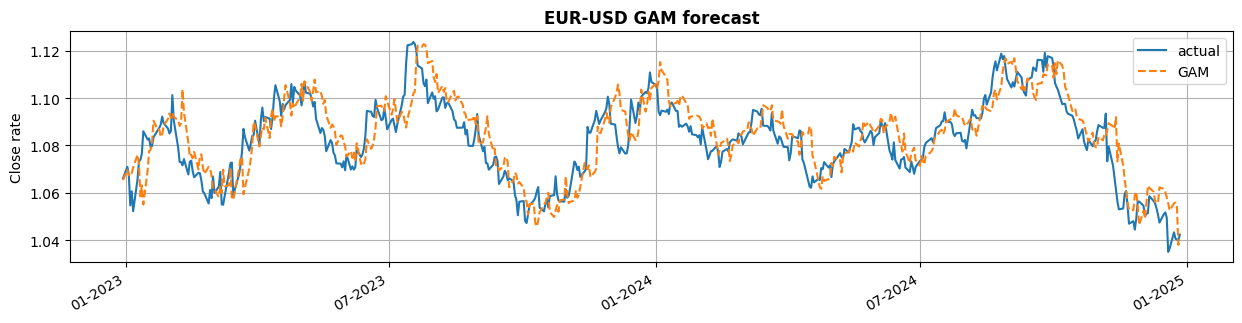

In [33]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=eur_usd_test, label='actual')
ax.plot('date', 'Close_gam', data=eur_usd_test, linestyle='--', label='GAM')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('EUR-USD GAM forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [34]:
gam_metrics = calculate_metrics(eur_usd_test, actual_col='Close', benchmark_cols=['Close_gam'])
gam_metrics

,Close_gam
MAE,0.0076
MSE,0.0001
RMSE,0.0096
MAPE,0.7000
R2,0.6777


# Neural Nets

In [35]:
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM, GRU

In [49]:

window_size = 20
scaler = MinMaxScaler().fit(eur_usd_train[['Close']])
close_scaled_train = scaler.transform(eur_usd_train[['Close']])
close_scaled_test = scaler.transform(eur_usd_test[['Close']])
close_scaled_test = np.concatenate((close_scaled_train[-window_size:], close_scaled_test), axis=0)


def preprocess(series, window_size):
    sequences = []
    targets = []
    for i in range(len(series)-window_size):
        sequences.append(series[i:i+window_size])
        targets.append(series[i+window_size])
        
    X = np.array(sequences)
    y = np.array(targets)

    return X, y

def lstm_model():
    model = Sequential()
    model.add(LSTM(10, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    return model

def gru_model():
    model = Sequential()
    model.add(GRU(10, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    return model

In [50]:
X_train, y_train = preprocess(close_scaled_train, window_size)
X_test, y_test = preprocess(close_scaled_test, window_size)

lstm_model = lstm_model()
lstm_model.fit(X_train, y_train, epochs=5, batch_size=1) 

gru_model = gru_model()
gru_model.fit(X_train, y_train, epochs=5, batch_size=1) 

Epoch 1/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0106
Epoch 2/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.4086e-04
Epoch 3/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.3709e-04
Epoch 4/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.0272e-04
Epoch 5/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.4557e-04
Epoch 1/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0442
Epoch 2/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.7472e-04
Epoch 3/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.6406e-04
Epoch 4/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.8191e-04
Epoch 5/5
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.3800e-04


In [51]:
lstm_preds = lstm_model.predict(X_test)
eur_usd_test['Close_lstm'] = scaler.inverse_transform(lstm_preds)

gru_preds = lstm_model.predict(X_test)
eur_usd_test['Close_gru'] = scaler.inverse_transform(gru_preds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


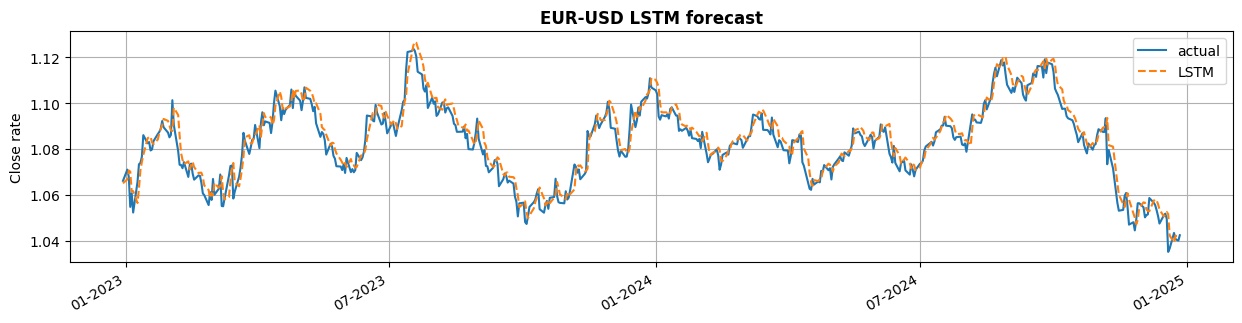

In [56]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=eur_usd_test, label='actual')
ax.plot('date', 'Close_lstm', data=eur_usd_test, linestyle='--', label='LSTM')
# ax.plot('date', 'Close_gru', data=eur_usd_test, linestyle='--', label='GRU')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('EUR-USD LSTM forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [53]:
nn_metrics = calculate_metrics(eur_usd_test, actual_col='Close', benchmark_cols=['Close_lstm', 'Close_gru'])
nn_metrics

,Close_lstm,Close_gru
MAE,0.0040,0.0040
MSE,0.0000,0.0000
RMSE,0.0051,0.0051
MAPE,0.3690,0.3690
R2,0.9080,0.9080


# Gradient Boosting

In [57]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
import math

In [75]:
def gb_model(X_train, y_train):
    param_grid = {
    'objective': ['reg:squarederror'],
    'eval_metric': ['logloss'],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'gamma':[0, 0.01, 0.1], 
    'max_depth': [2, 3, 4]
    }

    # len(Xtrain)/n_splits - gaps * n_splits - 1  
    testSize = math.floor(len(X_train) / 4) - 4 - 1

    # time series split for cross validation
    # tss = TimeSeriesSplit(n_splits=4, test_size=testSize, gap=1)
    
    #create model and tune hyperparameters
    xgb_model = XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2')
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_

In [76]:
df_train_copy = eur_usd_train.copy()
df_train_copy['date'] = pd.to_datetime(df_train_copy['date'])
df_train_copy['year'] = df_train_copy['date'].dt.year
df_train_copy['month'] = df_train_copy['date'].dt.month
df_train_copy['day'] = df_train_copy['date'].dt.day
df_train_copy['weekday'] = df_train_copy['date'].dt.weekday

features = ['year','month','day', 'weekday']
X_train = df_train_copy[features]
y_train = df_train_copy['Close'] 

df_test_copy = eur_usd_test.copy()
df_test_copy['date'] = pd.to_datetime(df_test_copy['date'])
df_test_copy['year'] = df_test_copy['date'].dt.year
df_test_copy['month'] = df_test_copy['date'].dt.month
df_test_copy['day'] = df_test_copy['date'].dt.day
df_test_copy['weekday'] = df_test_copy['date'].dt.weekday

X_test = df_test_copy[features]
y_test = df_test_copy['Close']

gb = gb_model(X_train, y_train)

In [77]:
eur_usd_test['Close_gb'] = gb.predict(X_test)
eur_usd_test['Close_gb']


2081    1.101504
2082    1.131087
2083    1.131087
2084    1.131087
2085    1.131087
          ...   
2597    1.101504
2598    1.101504
2599    1.101504
2600    1.101504
2601    1.101504
Name: Close_gb, Length: 521, dtype: float32

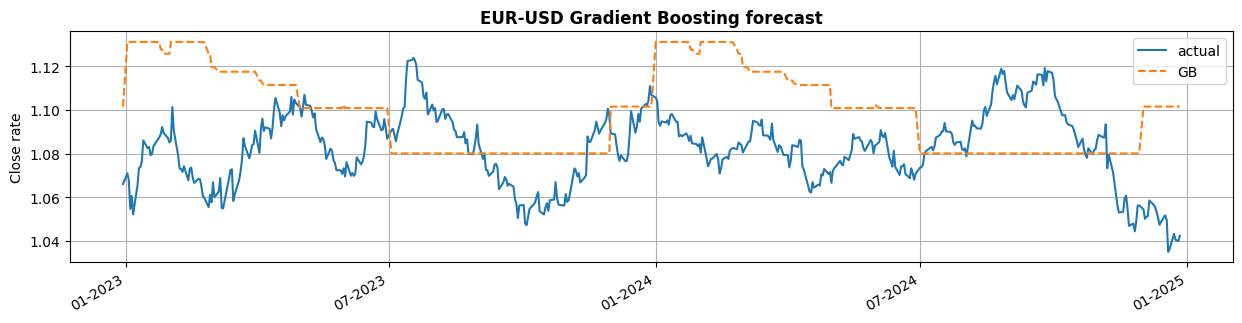

In [79]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=eur_usd_test, label='actual')
ax.plot('date', 'Close_gb', data=eur_usd_test, linestyle='--', label='GB')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('EUR-USD Gradient Boosting forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [82]:
gb_metrics = calculate_metrics(eur_usd_test, actual_col='Close', benchmark_cols=['Close_gb'])
gb_metrics

,Close_gb
MAE,0.0267
MSE,0.0010
RMSE,0.0319
MAPE,2.4736
R2,-2.5602
